# Automatic anomaly detection using the Brildata model 

Lets begin by importing our packages and loading our data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
import warnings
import json
warnings.filterwarnings("ignore")

In [3]:
from src.model.searcher import AnomalySearcher
from src.data.mounting_tool import MountData

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns


### Importing and cleaning the data

In setmount we have a little script to create the mount to the dessired data.
Modify the bash script to make it work for your computing account and cmsusr


In [5]:
MOUNT_TARGET = "/afs/cern.ch/user/j/jmunozar/private/InProcess/plt/mounts/h5s/"

In [6]:
with open('../secrets.json', "r") as f:
    config = json.load(f)
mounter = MountData(user="jmunozar", password=config["pass"])
mounter.create_mount(mount_source="brildev1:/brildata/22/", 
                     mount_target=MOUNT_TARGET)

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# Usage

To create a anomaly detector, simply provide the `AnomalySearcher` class the path to where the brildata is mounted

In [7]:
anm_searcher = AnomalySearcher(MOUNT_TARGET)

Data mount found


And now, lets select a Fill to analyze, this is direct:

In [8]:
FILL_N = 8395
anomaly_dict = anm_searcher(FILL_N,
                            return_preprocessed=True,
                            return_original=True,
                            save_path = f"/afs/cern.ch/user/j/jmunozar/private/InProcess/anomalies_results")

Running pipeline...
Found 10 runs for fill 8395
group ``/`` does not have a child named ``pltaggzero``
/afs/cern.ch/user/j/jmunozar/private/InProcess/plt/mounts/h5s/8395/8395_362053_2211141415_2211141437.hd5 does not contain dessired data
Problem with fill 8395, 0
'NoneType' object has no attribute 'pivot_table'
group ``/`` does not have a child named ``pltaggzero``
/afs/cern.ch/user/j/jmunozar/private/InProcess/plt/mounts/h5s/8395/8395_362056_2211141437_2211141444.hd5 does not contain dessired data
Problem with fill 8395, 1
'NoneType' object has no attribute 'pivot_table'


In [9]:
anomaly_dict.keys()

dict_keys(['fill_number', 'anomalies', 'preprocessed', 'original'])

In [10]:
from dataclasses import dataclass
from adtk.visualization import plot
from adtk.detector import LevelShiftAD

In [11]:
class AnomalyTypeTagger:
    def __init__(self, detector_output):
        self.detector_output = detector_output
        self.original_df = detector_output["original"][::10]
        self.processed_df = detector_output["preprocessed"][::10]
        self.esd_ad = LevelShiftAD(c=20.0, side='positive', window=50)
        
    def _transform_diff(self, df: pd.Series):
        diff = np.diff(df.values)
        return (diff/np.max(diff))**5

    def _positive_changes(self, df: pd.Series):
        diff = self._transform_diff(df)
        diff[diff < 0] = 0
        return diff

    def _negative_changes(self, df: pd.Series):
        diff = self._transform_diff(df)
        diff[diff > 0] = 0
        a_diff = np.abs(diff)
        return a_diff
    
    def get_ch_tags(self):
        anomalies_found = self.detector_output["anomalies"]
        channels_to_study = []
        for ch, info in anomalies_found.items():
            if len(info.keys()) > 0:
                channels_to_study.append(ch)
        return channels_to_study
    
    def study_ch(self, ch_id):
        pp_ch = self.processed_df[ch_id]
        pos_diff = self._positive_changes(pp_ch)
        neg_diff = self._negative_changes(pp_ch)
        sub_dt = pp_ch.index.values[:len(pos_diff)]
        p_anomalies = pd.DataFrame({"dt": sub_dt, ch_id: pos_diff}).set_index("dt")
        n_anomalies = pd.DataFrame({"dt": sub_dt, ch_id: neg_diff}).set_index("dt")
        sns.lineplot(pp_ch)
        
        pos_anomalies = self.esd_ad.fit_detect(p_anomalies)
        neg_anomalies = self.esd_ad.fit_detect(n_anomalies)
        return pos_anomalies, neg_anomalies
    
    def plot_ch_anomalies(self, ch_df):
        pos_anomalies, neg_anomalies = self.study_ch(ch_df)
        plot(self.original_df[ch_df].iloc[:len(pos_anomalies)],
             anomaly=pos_anomalies, anomaly_color='red', )
        plot(self.original_df[ch_df].iloc[:len(neg_anomalies)],
             anomaly=neg_anomalies, anomaly_color='blue',)

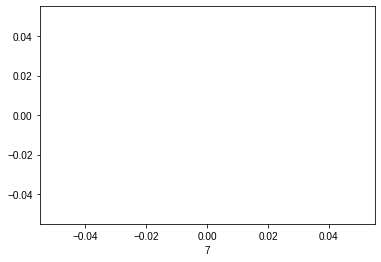

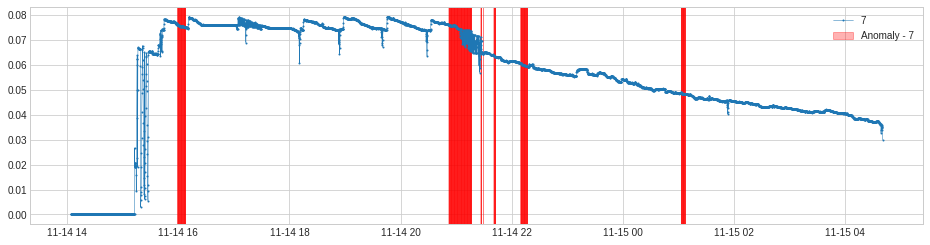

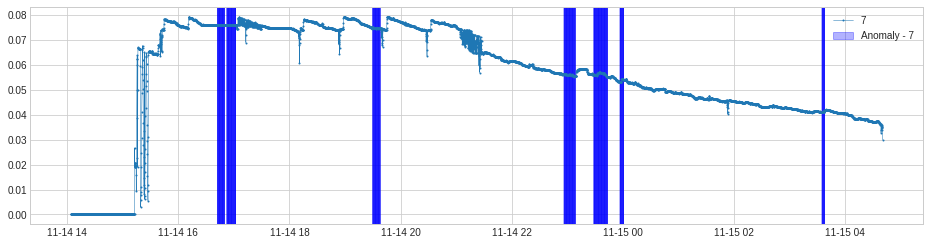

In [12]:
analizer = AnomalyTypeTagger(anomaly_dict)
analizer.plot_ch_anomalies(7)
